# Count number of items on image

Distribution centers often use robots to move objects as a part of their operations. Objects are carried in bins which can contain multiple objects. In this project, you will have to build a model that can count the number of objects in each bin. A system like this can be used to track inventory and make sure that delivery consignments have the correct number of items

In [1]:
!pip install smdebug torch torchvision tqdm --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
import sagemaker
import boto3

In [14]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-360461483855
AWS Region: us-east-1
RoleArn: arn:aws:iam::360461483855:role/service-role/AmazonSageMaker-ExecutionRole-20230320T170731


## Data Preparation
The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [7]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))


In [8]:
#Downloading files
download_and_arrange_data()

100%|██████████| 1228/1228 [01:36<00:00, 12.78it/s]


100%|██████████| 2299/2299 [03:00<00:00, 12.71it/s]


100%|██████████| 2666/2666 [03:33<00:00, 12.51it/s]


100%|██████████| 2373/2373 [03:06<00:00, 12.75it/s]


100%|██████████| 1875/1875 [02:22<00:00, 13.13it/s]


In [10]:
train_path = "train_data"

## Dataset
Cell above downloaded multiple images with differen numbers of objects in bins: {1,2,3,4,5}. The full dataset is avaiable [here](https://registry.opendata.aws/amazon-bin-imagery/).


In [12]:
# Print statistics about the dataset
import os

main_dirs = os.listdir(train_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(train_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


In [13]:
print(num_items.keys())

dict_keys(['1', '2', '3', '4', '5'])


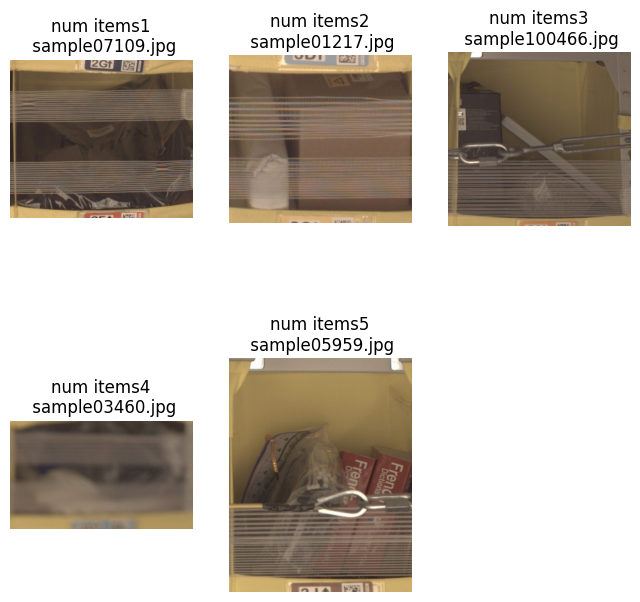

In [15]:
# Plot some of the data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample"+ img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(train_path, key, img_filename)).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_dataset_images.png')

## Dataset division into test-valid-train
 Train: 60%, Test: 20%, Valid: 40%

In [16]:
# Select files for each collection
file_list_train = {}
file_list_test = {}
file_list_valid = {}
for key in num_items.keys():
    valid_no = int(0.2*num_items[key])
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no - valid_no)
    file_list_valid[key] = []
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if idx < valid_no:
            file_list_valid[key].append(filename)
        elif (idx >= valid_no and idx<(test_no+valid_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Valid: {valid_no}, Test: {test_no}, Train: {train_no}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [18]:
import shutil
import os

subdivided_localdata_path = 'data_divided'

try:
    os.mkdir(subdivided_localdata_path)
    os.mkdir(os.path.join(subdivided_localdata_path, 'valid'))
    os.mkdir(os.path.join(subdivided_localdata_path, 'test'))
    os.mkdir(os.path.join(subdivided_localdata_path, 'train'))
except OSError as error:
    print(error)   

for key in num_items.keys():
    try:
        os.mkdir(os.path.join(subdivided_localdata_path, 'valid', key))
        os.mkdir(os.path.join(subdivided_localdata_path, 'test', key))
        os.mkdir(os.path.join(subdivided_localdata_path, 'train', key))
    except OSError as error:
        print(error)
        
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(train_path, key, filename), os.path.join(subdivided_localdata_path,'valid', key, filename))
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(train_path, key, filename), os.path.join(subdivided_localdata_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(train_path, key, filename), os.path.join(subdivided_localdata_path,'train', key, filename))
        
        
print('Copy completed')

[Errno 17] File exists: 'data_divided'
[Errno 17] File exists: 'data_divided/valid/1'
Copy completed


In [19]:
# Upload the data to AWS S3
import os
subdivided_localdata_path = 'data_divided'
bucket_path = "s3://"+ bucket
database_path = os.path.join(bucket_path, subdivided_localdata_path)
print(f"Path to used bucket: {bucket_path}")
print(f"Path to dataset in S3: {database_path}")

Path to used bucket: s3://sagemaker-us-east-1-360461483855
Path to dataset in S3: s3://sagemaker-us-east-1-360461483855/data_divided


In [20]:
# %%capture
# Warning - uploading is time and resource consuming. You can be charged for that
import os
os.environ["DATABASE_PATH"] = database_path
os.environ["DATABASE_ORIGIN_PATH"] = subdivided_localdata_path
!aws s3 sync ${DATABASE_ORIGIN_PATH} ${DATABASE_PATH}

upload: data_divided/test/1/03410.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03410.jpg
upload: data_divided/test/1/03416.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03416.jpg
upload: data_divided/test/1/03442.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03442.jpg
upload: data_divided/test/1/03440.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03440.jpg
upload: data_divided/test/1/03587.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03587.jpg
upload: data_divided/test/1/03565.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03565.jpg
upload: data_divided/test/1/03545.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03545.jpg
upload: data_divided/test/1/03576.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03576.jpg
upload: data_divided/test/1/03497.jpg to s3://sagemaker-us-east-1-360461483855/data_divided/test/1/03497.jpg
upload: data_divide

## Model Training
Here we train the model.
1. First we tune hyperparameters
1. Secondly we train using identified parameters (with optional concurrency)

**Info** This code utilizes multiple `*.py` files: `hpo.py` and `train.py`

import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os### Hyperparameter tuning
For simplicity tuning will be performed on a single epoch, using only 10% of the dataset. It will speed up the HP tuning proces.

In [21]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os

#### Set HP optimization ranges

In [22]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

#### Testing python script
In order to quickly verify the python script used for training I simply run it using local data as input

In [23]:
## Optional - uncomment if needed
os.environ["SM_CHANNEL_TRAINING"] = subdivided_localdata_path
os.environ["SM_MODEL_DIR"] = '.'
!python hpo.py --learning_rate 0.1 --batch_size 32

Arguments: Namespace(batch_size=32, data='data_divided', learning_rate=0.1, model_dir='.')
Hyperparameters are LR: 0.1, Batch Size: 32
Data Paths: data_divided
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|███████████████████████████████████████| 97.8M/97.8M [00:00<00:00, 204MB/s]
Starting Model Training
Epoch: 0, phase train
Epoch 0, Phase train, Images [32/6269 (1%)] Loss: 1.65 Accuracy: 5.0/32 (15.62%)
Epoch 0, Phase train, Images [64/6269 (1%)] Loss: 317.45 Accuracy: 11.0/64 (17.19%)
Epoch 0, Phase train, Images [96/6269 (2%)] Loss: 334.97 Accuracy: 19.0/96 (19.79%)
Epoch 0, Phase train, Images [128/6269 (2%)] Loss: 245.54 Accuracy: 26.0/128 (20.31%)
Epoch 0, Phase train, Images [160/6269 (3%)] Loss: 251.23 Accuracy: 33.0/160 (20.62%)
Epoch 0, Phase train, Images [192/6269 (3%)] Loss: 158.75 Accuracy: 36.0/192 (18.75%)
Epoch 0, Phase train, Images [224/6269 (4%)] Loss: 40.86 Accuracy: 3

#### Run optimization
Run HP optimization in at max 10 parallel job. Thanks to limitions of epochs and dataset they should finish relatively fast

In [24]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='HP search',
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=10,
    objective_type=objective_type
)

In [25]:
# All macros defined in cells above
os.environ["SM_CHANNEL_TRAINING"] = database_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" # where model will be stored
tuner.fit({"training": database_path}, wait = False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [26]:
latest_hyperparameter_tuning_job_name = tuner.latest_tuning_job.name
print(latest_hyperparameter_tuning_job_name)

pytorch-training-230323-1242


In [27]:
# Describe tuning results
from sagemaker.analytics import HyperparameterTuningJobAnalytics

exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=latest_hyperparameter_tuning_job_name)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
7,"""128""",0.018823,pytorch-training-230323-1242-003-817a7b53,Completed,10.720537,2023-03-23 12:43:38+00:00,2023-03-23 12:51:17+00:00,459.0
0,"""512""",0.006630,pytorch-training-230323-1242-010-149b8e3b,Completed,5.749516,2023-03-23 12:44:14+00:00,2023-03-23 12:53:23+00:00,549.0
1,"""512""",0.005098,pytorch-training-230323-1242-009-3e503bb4,Completed,5.037529,2023-03-23 12:43:44+00:00,2023-03-23 12:53:08+00:00,564.0
2,"""256""",0.005156,pytorch-training-230323-1242-008-245eb3c6,Completed,2.995530,2023-03-23 12:43:51+00:00,2023-03-23 12:52:10+00:00,499.0
3,"""256""",0.003848,pytorch-training-230323-1242-007-346646f2,Completed,2.161342,2023-03-23 12:43:44+00:00,2023-03-23 12:51:42+00:00,478.0
4,"""256""",0.002657,pytorch-training-230323-1242-006-9e204b00,Completed,2.065357,2023-03-23 12:43:38+00:00,2023-03-23 12:52:03+00:00,505.0
5,"""256""",0.002315,pytorch-training-230323-1242-005-3a0736a8,Completed,2.042242,2023-03-23 12:43:49+00:00,2023-03-23 12:51:57+00:00,488.0
8,"""64""",0.001182,pytorch-training-230323-1242-002-9e01b54d,Completed,1.714830,2023-03-23 12:43:32+00:00,2023-03-23 12:51:06+00:00,454.0
6,"""256""",0.001106,pytorch-training-230323-1242-004-12bc5fdc,Completed,1.634886,2023-03-23 12:43:32+00:00,2023-03-23 12:51:40+00:00,488.0
9,"""32""",0.001285,pytorch-training-230323-1242-001-67e66aed,Completed,1.616939,2023-03-23 12:43:27+00:00,2023-03-23 12:50:45+00:00,438.0


In [28]:
best_estimator=tuner.best_estimator()


2023-03-23 12:50:47 Starting - Preparing the instances for training
2023-03-23 12:50:47 Downloading - Downloading input data
2023-03-23 12:50:47 Training - Training image download completed. Training in progress.
2023-03-23 12:50:47 Uploading - Uploading generated training model
2023-03-23 12:50:47 Completed - Resource retained for reuse


In [29]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0012853059164119611',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"HP search-2023-03-23-12-42-21-659"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-360461483855/HP search-2023-03-23-12-42-21-659/source/sourcedir.tar.gz"'}

In [30]:

hyperparameter_values = {
    "learning_rate": 0.0012853059164119611,
    "batch_size": 32,
}
hyperparameter_values

{'learning_rate': 0.0012853059164119611, 'batch_size': 32}

### Train network
This time use full dataset and max 5 epochs.

In [31]:
# Set up debugging rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [32]:
# Set up profiling rules
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [33]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1, # here we can specify multiple instances for concurrent training, but I would like to use only one here
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [34]:
## Training file can be run independently -- for example using EC2 instance or offline machine
## In this case the 'debug' option will not work, but it is properly handled by the pthon code
os.environ["SM_CHANNEL_TRAINING"] = subdivided_localdata_path
os.environ["SM_MODEL_DIR"] = '.'
!python train.py --learning_rate 0.1 --batch_size 516

[2023-03-23 13:02:46.894 ip-172-16-118-1.ec2.internal:26276 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-23 13:02:47.436 ip-172-16-118-1.ec2.internal:26276 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Arguments: Namespace(batch_size=516, data='data_divided', learning_rate=0.1, model_dir='.')
Hyperparameters are LR: 0.1, Batch Size: 516
Data Paths: data_divided
Creating debug hook
Debug hook not avaiable. Skipping...
Starting Model Training
Epoch: 0, Phase: train


In [35]:
# Actual training
os.environ["SM_CHANNEL_TRAINING"] = database_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" # where model will be stored
estimator.fit({"training": database_path}, wait=False)
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-23-13-05-14-314


Job name: pytorch-training-2023-03-23-13-05-14-314
Debug artifacts path s3://sagemaker-us-east-1-360461483855/pytorch-training-2023-03-23-13-05-14-314/debug-output


### Print the latest training job’s rule summary in real time

In [ ]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f'job_name: {job_name}')
print(f'client: {client}')

In [3]:
job_name = "pytorch-training-2023-03-23-13-05-14-314"
client = boto3.client("sagemaker")
description = client.describe_training_job(TrainingJobName=job_name)

print(f'job_name: {job_name}')
print(f'client: {client}')

job_name: pytorch-training-2023-03-23-13-05-14-314
client: <botocore.client.SageMaker object at 0x7f3bb45fc850>


In [4]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # in seconds

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Check Training Performance
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

debug_artifacts_path = "s3://sagemaker-us-east-1-360461483855/pytorch-training-2023-03-23-13-05-14-314/debug-output"

trial = create_trial(debug_artifacts_path)

[2023-03-26 07:58:22.341 ip-172-16-100-47.ec2.internal:13974 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-360461483855/pytorch-training-2023-03-23-13-05-14-314/debug-output
[2023-03-26 07:58:22.920 ip-172-16-100-47.ec2.internal:13974 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4747 more expected)', IncompleteRead(0 bytes read, 4747 more expected)) while reading s3://sagemaker-us-east-1-360461483855/pytorch-training-2023-03-23-13-05-14-314/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [6]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [3]:
print("No of TRAIN datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))))
print("No of EVAL datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))))

[2023-03-26 07:59:14.279 ip-172-16-100-47.ec2.internal:13974 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-26 07:59:15.297 ip-172-16-100-47.ec2.internal:13974 INFO trial.py:210] Loaded all steps
No of TRAIN datapoints 40
No of EVAL datapoints 80


In [4]:
# Define plotting functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name,filename):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig(filename)

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


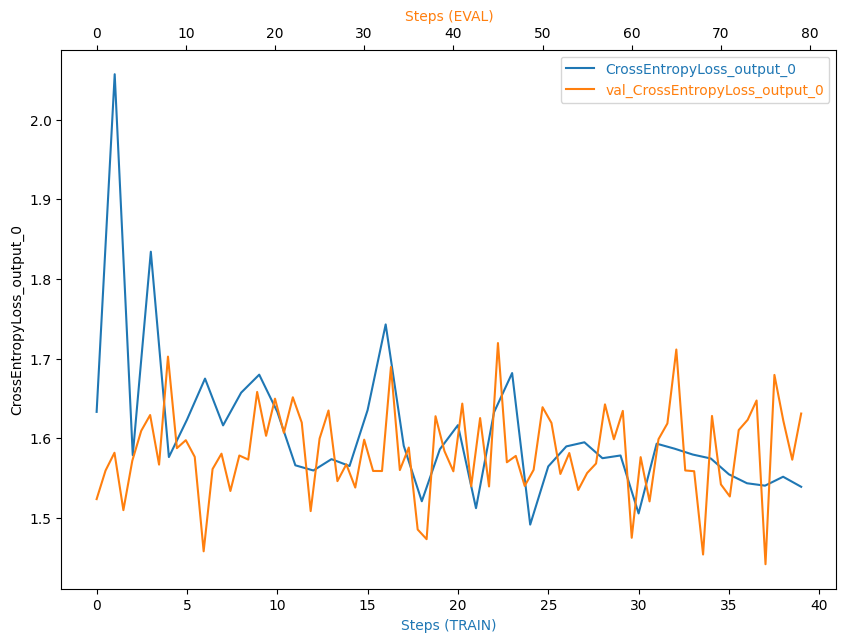

In [5]:
# Plot output
plot_tensor(trial, "CrossEntropyLoss_output_0",'"training_debug_values.png")

## Running inference on trained model
After succesfull training let's run inference using sample image and check if the model is actually working.

This stage consists of following steps:
1. Locate model
1. Create ImagePredictor and inference python file, which can be used to run the model anywhere -- file `inference.py`
1. Create AWS endpoint
1. Use endpoint for inference


In [9]:
# model_location=estimator.model_data
model_location = "s3://sagemaker-us-east-1-360461483855/pytorch-training-2023-03-23-13-05-14-314/output/model.tar.gz"
print(model_location)

s3://sagemaker-us-east-1-360461483855/pytorch-training-2023-03-23-13-05-14-314/output/model.tar.gz


In [12]:
# create ImagePredictor - without it the Image function won't be able to decode bytes
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [15]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [16]:
# This command takes long time to execute - it creates an endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [33]:
# Plot requested image
from PIL import Image
import io

with open("train_data/2/00025.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)
    Image.open(io.BytesIO(img_bytes))

In [34]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [36]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

import torch
import numpy as np
print(np.argmax(response, 1))
print("Expected answer: 2")

Raw prediction result:
[[-0.5008819103240967, 0.44975075125694275, 0.5678279995918274, -0.060949090868234634, -0.14262714982032776]]

Labeled predictions: 
[(0, -0.5008819103240967), (1, 0.44975075125694275), (2, 0.5678279995918274), (3, -0.060949090868234634), (4, -0.14262714982032776)]

Most likely answer: (2, 0.5678279995918274)
[2]
Expected answer: 2


In [37]:
# Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()